# Sampling from a multivariate Normal distribution

Lets import some libraries that we're going to use. 

We're going to need:

 - *numpy* because there's nothing we can do without it,
 - *sklearn* to produce a mock covariance matrix for the normal distribution,
 - *matplotlib* to plot the covariance matrix and visually inspect our results,
 - *getdist* to plot the marginalised posterior distributions,
 
and of course  **zeus** to perform MCMC Bayesian Inference.

In [1]:
import numpy as np
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
import zeus

Now we need to define:

 - *ndim* the number of dimensions/parameters of our distribution,
 - *nwalkers* the number of walkers, as a rule of thumb we choose the minimum value, twice the number of parameters,
 - *nsteps* the numper of steps/generations.
 
We also want to:

 - produce a mock covariance matrix using the *make_spd_matrix* function of *scikit-learn*,
 - compute its inverse,
 - define a random mean vector for our posterior distribution,
 - define the log probability of the posterior distribution as a python function,
 - provide a starting point for the sampler.

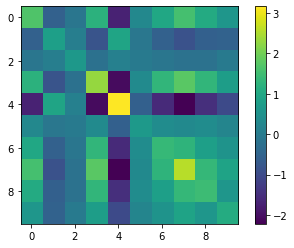

In [2]:
ndim = 10
nwalkers = 2*ndim
nsteps= 1000

C = make_spd_matrix(ndim)
plt.imshow(C)
plt.colorbar()
plt.show()

icov = np.linalg.inv(C)

mu = np.random.rand(ndim) * 100.0

def logprob(x, mu, icov):
    return -0.5 * np.dot(np.dot((x-mu).T,icov),(x-mu))

start = np.random.rand(nwalkers, ndim)

Now we are ready to do some inference.

 - First we initialise the sampler by calling the *zeus.sampler* class,
 - and then we run the MCMC by calling the *run* method.
 
This is going to be very fast.

In [3]:
sampler = zeus.sampler(logprob, nwalkers, ndim, args=[mu, icov])
sampler.run(start, nsteps)

100%|██████████| 1000/1000 [00:00<00:00, 1212.14it/s]


Alright, lets plot our chains to see what we've got.
The chains are stored in the *sampler.chain* property, their shape is (nwalkers, nsteps, ndim). So we want to iterate over all dimensions and plot the results. We also plot the true values of the parameters so that we can compare the results.

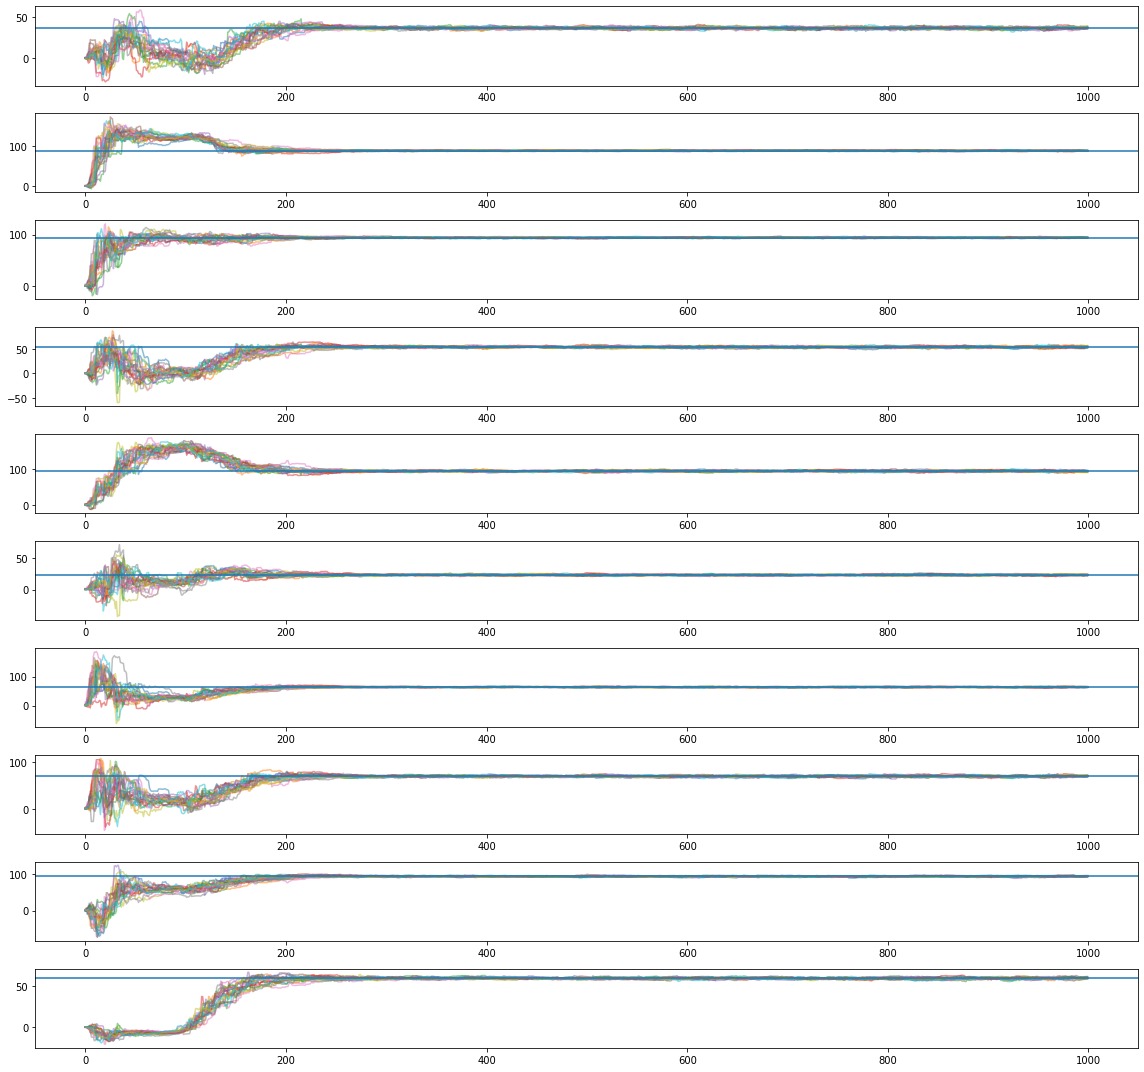

In [4]:
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(np.arange(nsteps),sampler.chain[:,:,n].T,alpha=0.5)
    plt.axhline(y=mu[n])
plt.tight_layout()
plt.show()

Great! This looks very good. It seems that the *burn-in* is over after the first ~200 iterations.

Now lets cut this burn-in phase off. We can either do this manually using *numpy* or even better use *zeus*'s flatten method. By default, flatten() removes the first half of the chains and the combines them. If we to remove a different number of samples from the begining of the chains we can provide this number as the burn argument (e.g. flatten(burn=200)).

In [5]:
trace = sampler.flatten()

We can now compute some usefull statistics:

In [6]:
print('Percentiles')
print (np.percentile(trace, [16, 50, 84], axis=0))
print('Mean')
print (np.mean(trace, axis=0))
print('Standard Deviation')
print (np.std(trace, axis=0))

Percentiles
[[35.44128283 87.33368542 93.2232653  52.13939042 91.78686689 22.24251685
  62.66801216 67.73587913 92.11769649 57.98211142]
 [36.72129953 88.21998231 94.04229248 53.66818633 93.71041321 23.08239156
  63.89670541 69.33720429 93.32936123 59.056393  ]
 [37.95967991 89.12159239 94.85543672 55.20385514 95.49618461 23.92367601
  65.08601848 70.9355874  94.57842813 60.09220583]]
Mean
[36.71009401 88.22433007 94.04484845 53.67248135 93.67387989 23.08846437
 63.89783867 69.3341384  93.33623404 59.04039871]
Standard Deviation
[1.25104439 0.90328425 0.8179669  1.55434571 1.86666956 0.85489014
 1.23702735 1.65341908 1.25522631 1.06101876]


Last but not least, we can also plot the marginalised posterior distributions:

Removed no burn in


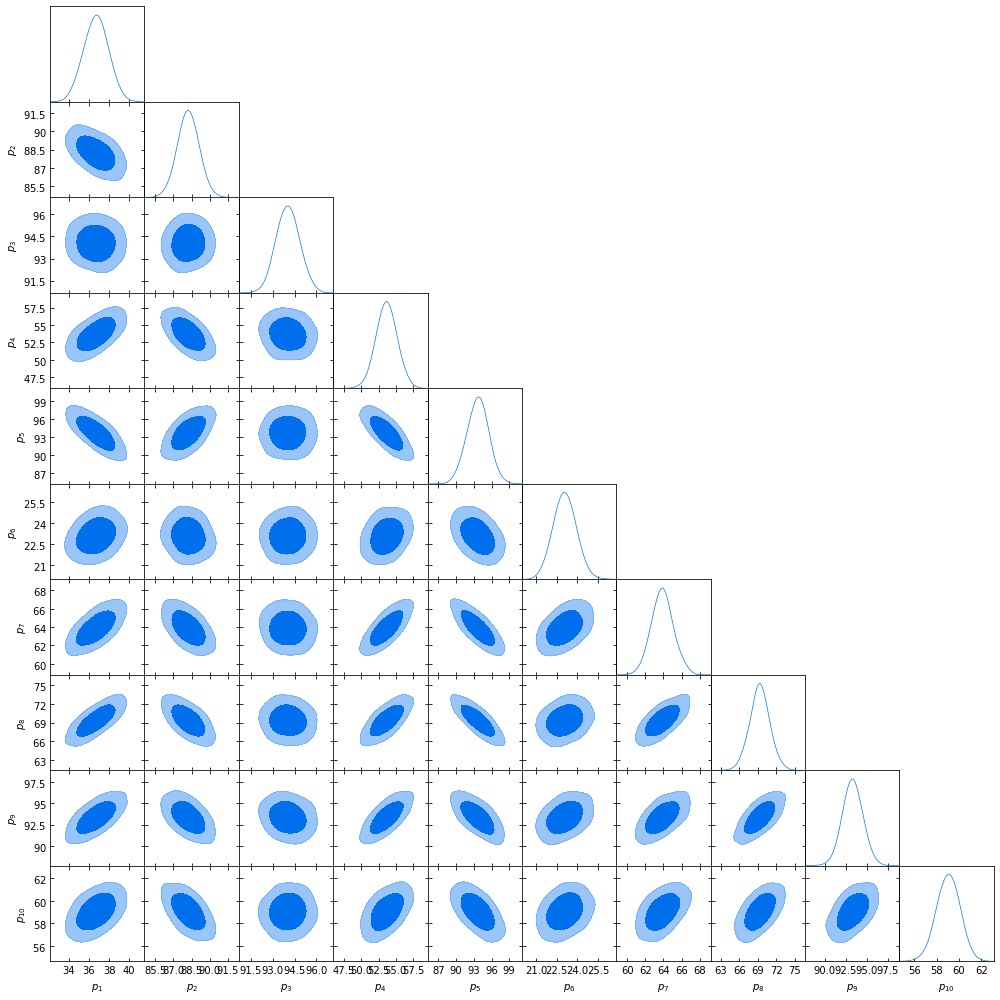

In [7]:
sample = MCSamples(samples=trace)
g = plots.getSubplotPlotter(width_inch=14)
g.triangle_plot([sample], filled=True, shaded=False) 